In [1]:
import numpy as np
import pandas as pd
import hickle as hkl

import numpy as np
import scipy.io as sio
from matplotlib import image
from scipy.cluster.vq import kmeans as km

import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from collections import Counter
from scipy.misc import imread, imresize, imsave

import rasterio
from rasterio.transform import from_origin
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%run ../src/downloading/utils.py
%run ../src/models/utils.py
from skimage.transform import resize

In [2]:
landscape = 'mantiquiera'

In [3]:
database = pd.read_csv("../project-monitoring/database.csv")
coords = database[database['landscape'] == landscape]
path = coords['path'].tolist()[0]
coords = (float(coords['longitude']), float(coords['latitude']))

IO_PARAMS = {'prefix': '../',
             'bucket': 'restoration-monitoring',
             'coords': coords,
             'bucket-prefix': '',
             'path': path}

TIF_OUTPUT = IO_PARAMS['prefix'] + IO_PARAMS['path'] + "gain.tif"
INPUT_FOLDER = IO_PARAMS['prefix'] + IO_PARAMS['path']

print(coords, INPUT_FOLDER)

(-46.30333374, -22.89661232) ../project-monitoring/brazil/sao-paulo/joanopolis/


In [4]:
max_x = 2
im1 = np.empty((646, 646*max_x, 16))
im2 = np.empty((646, 646*max_x, 16))

for x_val in range(0, max_x):
    image1 = hkl.load(f"{INPUT_FOLDER}/2017/interim/0_{x_val}.hkl")
    print(f"There are {np.sum(np.isnan(image1))} NA values in 2017")
    image1 = image1[..., :8]

    im1_med = np.median(image1, axis = 0)
    im1_stdev = np.std(image1, axis = 0)
    image1 = np.concatenate([im1_med, im1_stdev], axis = -1)
    im1[:, 646 * (x_val):646 * (x_val+1), :] = image1


    image2 = hkl.load(f"{INPUT_FOLDER}/2019/interim/0_{x_val}.hkl")
    print(f"There are {np.sum(np.isnan(image2))} NA values in 2019")
    image2 = image2[..., :8]

    im2_med = np.median(image2, axis = 0)
    im2_stdev = np.std(image2, axis = 0)
    image2 = np.concatenate([im2_med, im2_stdev], axis = -1)
    im2[:, 646 * (x_val):646 * (x_val+1), :] = image2
net_shape = [128, 128, 16]

There are 0 NA values in 2017
There are 0 NA values in 2019
There are 0 NA values in 2017
There are 0 NA values in 2019


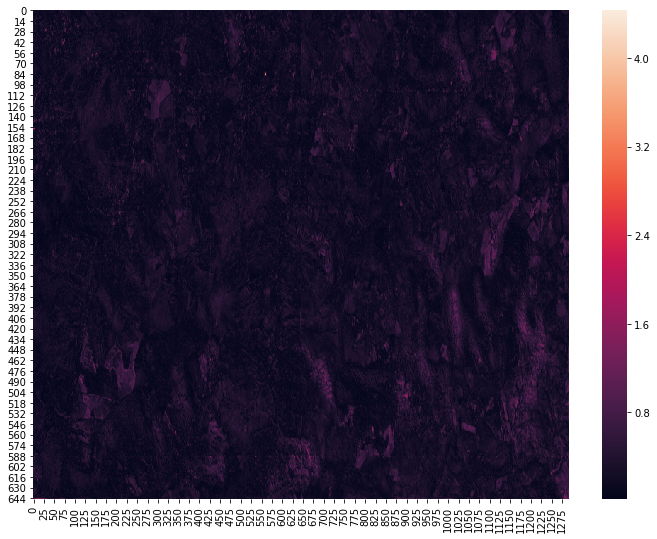

In [5]:
diff_image = np.sum(abs(im1 - im2), axis = -1)
plt.figure(figsize=(12, 9))
sns.heatmap(diff_image)

# Change vector analysis with canonical correlation analysis

4173.16


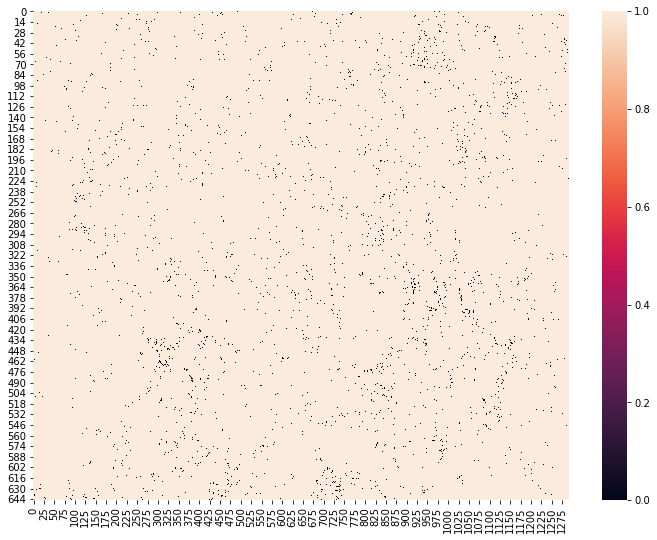

In [6]:
from sklearn.cross_decomposition import CCA
x = im1[:, ..., :16].reshape(646*646*max_x, 16)
y = im2[:, ..., :16].reshape(646*646*max_x, 16)
cca = CCA(n_components=3)
cca.fit(x, y)
xs = cca.transform(x)
ys = cca.transform(y)
diffs = abs(xs - ys)
diffs = np.sum(diffs, axis = 1)
#diffs = (diffs - np.mean(diffs)) / np.std(diffs)

diffs = diffs.reshape(646, 646*max_x)
cutoff = np.percentile(diffs.flatten(), 1)
print(len(diffs.flatten())/ 200)
new = np.ones_like(diffs)
new[np.where(diffs < cutoff)] = 0.
plt.figure(figsize=(12, 9))
sns.heatmap(new)


# Deep slow feature analysis

In [7]:
def getTrainSamples(index, im1, im2, number=4000):

    loc = np.where(index != 1)[0]
    perm = np.random.permutation(np.shape(loc)[0])

    ind = loc[perm[0:number]]

    return im1[ind, :], im2[ind, :]


def normlize(data):
    meanv = np.mean(data, axis=0)
    stdv = np.std(data, axis=0)

    delta = data - meanv
    data = delta / stdv

    return data


def linear_sfa(fcx, fcy, vp, shape):

    delta = np.matmul(fcx, vp) - np.matmul(fcy, vp)
    #delta = delta / np.std(delta, axis=0)
    #delta = delta**2
    differ_map = delta#normlize(delta)
    # / np.var(delta, axis = 0)
    magnitude = np.sum(delta**2 / np.var(delta, axis = 0), axis=1)
    vv = magnitude / np.max(magnitude)
    im = np.reshape(kmeans(vv), shape[0:-1])
    return im, magnitude, differ_map


def kmeans(data):
    shape = np.shape(data)
    # print((data))
    ctr, _ = km(data, 2)

    for k1 in range(shape[0]):
        if abs(ctr[0] - data[k1]) >= abs(ctr[1] - data[k1]):
            data[k1] = 0
        else:
            data[k1] = 1
    return data

In [8]:
import numpy as np
import tensorflow as tf
import logging

logging.basicConfig(format='%(asctime)-15s %(levelname)s: %(message)s', datefmt='%m/%d/%Y %H:%M:%S', level=logging.INFO)

def dsfa(xtrain, ytrain, xtest, ytest, net_shape=None):

    train_num = np.shape(xtrain)[0]
    bands = np.shape(xtrain)[-1]

    tf.reset_default_graph()

    activation = tf.nn.softsign

    xd = tf.placeholder(dtype=tf.float32, shape=[None, bands])
    yd = tf.placeholder(dtype=tf.float32, shape=[None, bands])

    # fc1
    fc1w1 = tf.Variable(tf.truncated_normal(shape=[bands, net_shape[0]], dtype=tf.float32, stddev=1e-1))
    fc1w2 = tf.Variable(tf.truncated_normal(shape=[bands, net_shape[0]], dtype=tf.float32, stddev=1e-1))
    fc1b1 = tf.Variable(tf.constant(1e-1, shape=[net_shape[0]], dtype=tf.float32))
    fc1b2 = tf.Variable(tf.constant(1e-1, shape=[net_shape[0]], dtype=tf.float32))

    fc1x = tf.nn.bias_add(tf.matmul(xd, fc1w1), fc1b1)
    fc1y = tf.nn.bias_add(tf.matmul(yd, fc1w2), fc1b2)

    fc11 = activation(fc1x)
    fc12 = activation(fc1y)

    # fc2
    fc2w1 = tf.Variable(tf.truncated_normal(shape=[net_shape[0], net_shape[1]], dtype=tf.float32, stddev=1e-1))
    fc2w2 = tf.Variable(tf.truncated_normal(shape=[net_shape[0], net_shape[1]], dtype=tf.float32, stddev=1e-1))
    fc2b1 = tf.Variable(tf.constant(1e-1, shape=[net_shape[1]], dtype=tf.float32))
    fc2b2 = tf.Variable(tf.constant(1e-1, shape=[net_shape[1]], dtype=tf.float32))

    fc2x = tf.nn.bias_add(tf.matmul(fc11, fc2w1), fc2b1)
    fc2y = tf.nn.bias_add(tf.matmul(fc12, fc2w2), fc2b2)

    fc21 = activation(fc2x)
    fc22 = activation(fc2y)

    # fc3
    fc3w1 = tf.Variable(tf.truncated_normal(shape=[net_shape[1], net_shape[2]], dtype=tf.float32, stddev=1e-1))
    fc3w2 = tf.Variable(tf.truncated_normal(shape=[net_shape[1], net_shape[2]], dtype=tf.float32, stddev=1e-1))
    fc3b1 = tf.Variable(tf.constant(1e-1, shape=[net_shape[2]], dtype=tf.float32))
    fc3b2 = tf.Variable(tf.constant(1e-1, shape=[net_shape[2]], dtype=tf.float32))

    fc3x = tf.nn.bias_add(tf.matmul(fc21, fc3w1), fc3b1)
    fc3y = tf.nn.bias_add(tf.matmul(fc22, fc3w2), fc3b2)

    fc3x = activation(fc3x)
    fc3y = activation(fc3y)

    #fc3x - tf.cast(tf.divide(1, bands), tf.float32) * tf.matmul(fc3x, tf.ones([bands, bands]))
    m = tf.shape(fc3x)[1]
    fc_x = fc3x - tf.cast(tf.divide(1, m), tf.float32) * tf.matmul(fc3x, tf.ones([m, m]))
    fc_y = fc3y - tf.cast(tf.divide(1, m), tf.float32) * tf.matmul(fc3y, tf.ones([m, m]))

    Differ = fc_x - fc_y

    A = tf.matmul(Differ, Differ, transpose_a=True)
    A = A / train_num

    sigmaX = tf.matmul(fc_x, fc_x, transpose_a=True)
    sigmaY = tf.matmul(fc_y, fc_y, transpose_a=True)
    sigmaX = sigmaX / train_num + 1e-4  * tf.eye(net_shape[-1])
    sigmaY = sigmaY / train_num + 1e-4  * tf.eye(net_shape[-1])

    B = (sigmaX + sigmaY) / 2# + args.reg * tf.eye(net_shape[-1])

    # B_inv, For numerical stability.
    D_B, V_B = tf.self_adjoint_eig(B)
    idx = tf.where(D_B > 1e-12)[:, 0]
    D_B = tf.gather(D_B, idx)
    V_B = tf.gather(V_B, idx, axis=1)
    B_inv = tf.matmul(tf.matmul(V_B, tf.diag(tf.reciprocal(D_B))), tf.transpose(V_B))

    sigma = tf.matmul(B_inv, A)#+ args.reg * tf.eye(net_shape[-1])

    D, V = tf.self_adjoint_eig(sigma)
    
    #loss = tf.sqrt(tf.trace(tf.matmul(sigma,sigma)))
    loss = tf.trace(tf.matmul(sigma,sigma))

    optimizer = tf.train.GradientDescentOptimizer(1e-4).minimize(loss)

    init = tf.global_variables_initializer()

    loss_log = []

    #gpu_options = tf.GPUOptions(allow_growth = True)
    #conf        = tf.ConfigProto(gpu_options=gpu_options)
    sess = tf.Session()

    sess.run(init)
    #writer = tf.summary.FileWriter('graph')
    #writer.add_graph(sess.graph)

    for k in range(4000):
        sess.run(optimizer, feed_dict={xd: xtrain, yd: ytrain})

        if k % 100 == 0:
            ll = sess.run(loss, feed_dict={xd: xtrain, yd: ytrain})
            ll = ll / net_shape[-1]
            logging.info('The %4d-th epochs, loss is %4.4f ' % (k, ll))
            loss_log.append(ll)

    matV = sess.run(V, feed_dict={xd: xtest, yd: ytest})
    bVal = sess.run(B, feed_dict={xd: xtest, yd: ytest})

    fcx = sess.run(fc_x, feed_dict={xd: xtest, yd: ytest})
    fcy = sess.run(fc_y, feed_dict={xd: xtest, yd: ytest})

    sess.close()
    print('')

    return loss_log, matV, fcx, fcy, bVal

In [9]:
img_shape = np.shape(im1)

im1 = np.reshape(im1, newshape=[-1,img_shape[-1]])
im2 = np.reshape(im2, newshape=[-1,img_shape[-1]])

im1 = normlize(im1)
im2 = normlize(im2)

imm = None
all_magnitude = None
cva_new = new
#cva_new = np.zeros((646, 646))
#cva_new[np.where(diff_image < np.percentile(diff_image, 2))] = 1.
cva_ind = np.reshape(cva_new, newshape=[-1])

i1, i2 = getTrainSamples(cva_ind, im1, im2, 2000)


In [10]:
loss_log, vpro, fcx, fcy, bval = dsfa(xtrain=i1, ytrain=i2, xtest=im1, ytest=im2, net_shape=net_shape)


Instructions for updating:
Colocations handled automatically by placer.


09/28/2020 10:35:42 WARNING: From /Users/john.brandt/anaconda3/envs/remote_sensing/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use tf.cast instead.


09/28/2020 10:35:42 WARNING: From /Users/john.brandt/anaconda3/envs/remote_sensing/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
09/28/2020 10:35:42 INFO: The    0-th epochs, loss is 4.7346 
09/28/2020 10:35:43 INFO: The  100-th epochs, loss is 1.7472 
09/28/2020 10:35:44 INFO: The  200-th epochs, loss is 1.4247 
09/28/2020 10:35:44 INFO: The  300-th epochs, loss is 1.2718 
09/28/2020 10:35:45 INFO: The  400-th epochs, loss is 0.7988 
09/28/2020 10:35:46 INFO: The  500-th epochs, loss is 0.5314 
09/28/2020 10:35:46 INFO: The  600-th epochs, loss is 0.3904 
09/28/2020 10:35:47 INFO: The  700-th epochs, loss is 0.3294 
09/28/2020 10:35:48 INFO: The  800-th epochs, loss is 0.2928 
09/28/2020 10:35:49 INFO: The  900-th epochs, loss is 0.5274 
09/28/2020 10:35:49 INFO: The 1000-th epochs, loss is 0.2318 
09/28/2020 10:35:

In [11]:
imm, magnitude, differ_map = linear_sfa(fcx, fcy, vpro, shape=img_shape)

magnitude = np.reshape(magnitude, img_shape[0:-1])
magnitude_float = np.copy(magnitude)
differ = differ_map
change_map = np.reshape(kmeans(np.reshape(magnitude, [-1])), img_shape[0:-1])

In [12]:
magnitude_float2 = np.copy(magnitude_float)
magnitude_float2[np.where(magnitude_float2 > np.percentile(magnitude_float2, 95))] = np.percentile(magnitude_float2, 95)
magnitude_float2 = magnitude_float2 / np.percentile(magnitude_float2, 100)

indices = [(8, 638), (654, 1284)]
change_map = np.empty((630, 630*max_x))
for x_val in range(0, max_x):
    print(indices[x_val][0], indices[x_val][1])
    change_map[:, (630*x_val):(630*(x_val+1))] = magnitude_float2[8:-8, indices[x_val][0]:indices[x_val][1]]

8 638
654 1284


In [13]:
change_map.shape

(630, 1260)

In [14]:
point = bounding_box(coords, (5*max_x*1260)-0, ((5)*1260)-0, expansion = 0)
west = point[1][0]
east = point[0][0]
north = point[0][1]
south = point[1][1]

# Bayesian soft fusion

In [15]:
from PIL import Image
start_probs = np.array(Image.open(f'{INPUT_FOLDER}/2017.tif'))
middle_probs = np.array(Image.open(f'{INPUT_FOLDER}/2018.tif'))
end_probs = np.array(Image.open(f'{INPUT_FOLDER}/2019.tif'))

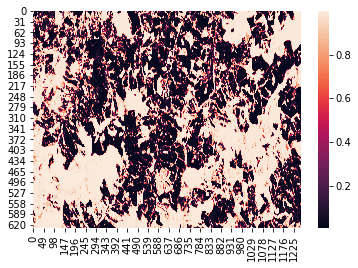

In [16]:
sns.heatmap(start_probs)

In [17]:
cv = change_map
cv[np.where(cv > 1)] = 1.

In [18]:
start_probs.shape

(630, 1260)

In [19]:
transform = rasterio.transform.from_bounds(west = west, south = south,
                                           east = east, north = north,
                                           width = cv.shape[1], height = cv.shape[1])

print("Writing", f'{INPUT_FOLDER}cva.tif')
new_dataset = rasterio.open(f'{INPUT_FOLDER}cva.tif', 'w', driver = 'GTiff',
                           height = cv.shape[1], width = cv.shape[1], count = 1,
                           dtype = 'float32',#str(stacked.dtype),
                           crs = '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs',
                           transform=transform)
new_dataset.write(cv.astype(np.float32), 1)
new_dataset.close()

Writing ../project-monitoring/brazil/sao-paulo/joanopolis/cva.tif


In [20]:
from itertools import product
possibilities = [list(x) for x in product([0, 1], [0, 1], [0, 1])]
print(possibilities)

[[0, 0, 0], [0, 0, 1], [0, 1, 0], [0, 1, 1], [1, 0, 0], [1, 0, 1], [1, 1, 0], [1, 1, 1]]


In [21]:
change_map = np.zeros((630, 630*max_x, 8))
for i, val in enumerate(possibilities):
    start = val[0]
    middle = val[1]
    end = val[2]
    if start == 1:
        pwi_x = start_probs
    else:
        pwi_x = 1 - start_probs
        
    if middle == 1:
        pxk_z = middle_probs
    else:
        pxk_z = 1 - middle_probs

    if end == 1:
        pvj_y = end_probs
    else:
        pvj_y = 1 - end_probs

    if start == end:
        pwi_vj = 1 - (cv)
    else:
        pwi_vj = (cv)
        
    #change_map = pwi_x * pvj_y * pxk_z

    prior = np.logical_and(pwi_x > 0.75, pvj_y > 0.75)
    prior = np.logical_and(prior, pxk_z > 0.75)

    change_map[prior, i] = pwi_x[prior] * pvj_y[prior] * pxk_z[prior]# * pwi_vj[prior] 
    change_map[~prior, i] = pwi_x[~prior] * pvj_y[~prior] * pxk_z[~prior] * pwi_vj[~prior] 

In [22]:
print(change_map.shape)

(630, 1260, 8)


In [23]:
change_map = np.argmax(change_map, axis = -1)
#change_new = np.zeros_like(change_map)
#gain_areas = np.logical_or(change_map == 1, change_map == 3)
#change_new[gain_areas] = 1. 

In [24]:
gain = np.copy(change_map)
#for x_window in range(1, change_new.shape[0] - 2, 2):
#    for y_window in range(1, change_new.shape[1] - 2, 2):
 #       if np.sum(change_new[x_window - 1:x_window + 1, y_window - 1:y_window + 1]) < 2:
 #           gain[x_window - 1:x_window + 1, y_window - 1:y_window + 1] *= 0

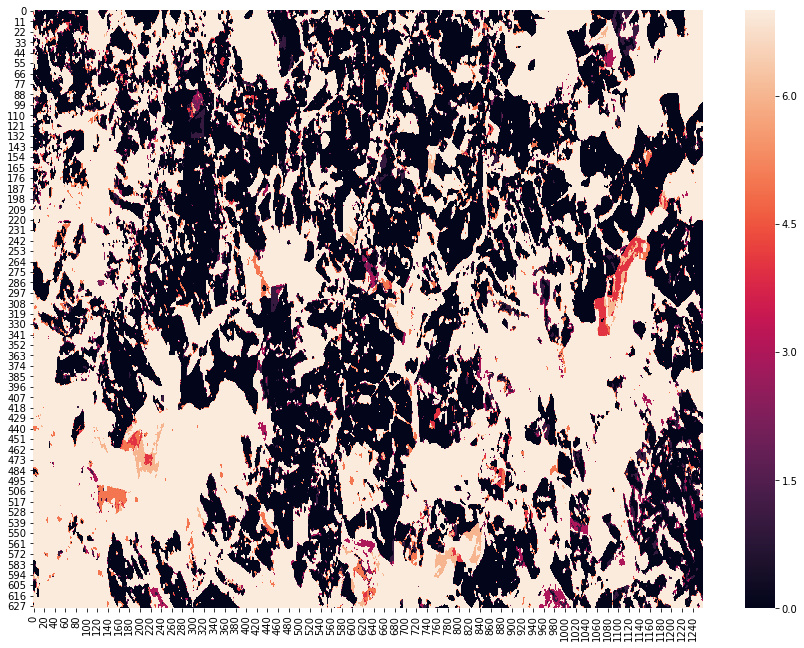

In [25]:
plt.figure(figsize=(15, 11))
sns.heatmap(gain)

In [26]:
transform = rasterio.transform.from_bounds(west = west, south = south,
                                           east = east, north = north,
                                           width = change_map.shape[1], height = change_map.shape[0])

print("Writing", f'{INPUT_FOLDER}gain.tif')
new_dataset = rasterio.open(f'{INPUT_FOLDER}gain.tif', 'w', driver = 'GTiff',
                           height = change_map.shape[0], width = change_map.shape[1], count = 1,
                           dtype = 'float32',#str(stacked.dtype),
                           crs = '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs',
                           transform=transform)
new_dataset.write(gain.astype(np.float32), 1)
new_dataset.close()

Writing ../project-monitoring/brazil/sao-paulo/joanopolis/gain.tif
